In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

def train_random_forest_model_corrected(glodap_path, model_save_path):
    print("--- RANDOM FOREST REGRESSOR TRAINING PIPELINE ---")

    # 1. Data Preparation (Load, Align, Clean)
    try:
        glodap_df = pd.read_csv(glodap_path)
    except FileNotFoundError:
        print(f"ERROR: GLODAP data file not found at '{glodap_path}'.")
        return None

    # --- Feature Alignment & Cleaning ---
    # We now use the exact column names you provided.

    # Filter for surface data (using the 'depth' column)
    aligned_df = glodap_df[glodap_df['depth'] <= 6].copy()

    # Define the features to be used for training, matching your satellite data.
    features_for_training = ['salinity', 'temperature', 'latitude', 'longitude', 'year', 'month']
    target_variable = 'talk'

    # Drop rows with any missing values in the required columns
    required_columns = features_for_training + [target_variable, 'depth']
    aligned_df.dropna(subset=required_columns, inplace=True)

    print(f"✓ Cleaned and filtered GLODAP data contains {len(aligned_df):,} samples.")

    # Quality Control
    initial_count = len(aligned_df)
    aligned_df = aligned_df[(aligned_df['salinity'] >= 32) & (aligned_df['salinity'] <= 38)]
    aligned_df = aligned_df[(aligned_df['temperature'] >= -2) & (aligned_df['temperature'] <= 32)]
    aligned_df = aligned_df[(aligned_df['talk'] >= 2000) & (aligned_df['talk'] <= 2500)]
    print(f"✓ QC completed. Removed {initial_count - len(aligned_df):,} outliers.")
    print(f"Final dataset size: {len(aligned_df):,} samples.")

    X = aligned_df[features_for_training]
    y = aligned_df[target_variable]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 2. Model Instantiation and Training
    print("\n2. Initializing and training Random Forest model...")
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    rf_model.fit(X_train, y_train)
    print("✓ Model training completed.")

    # 3. Evaluation and Saving
    print("\n3. Evaluating and saving the model...")
    y_test_pred = rf_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    print(f"MSE: {mse:.2f}, R²: {r2:.4f}")

    with open(model_save_path, 'wb') as f:
        pickle.dump(rf_model, f)
    print(f"✓ Model saved to '{model_save_path}'.")

    return rf_model

# Example usage (uncomment to run)
trained_rf_model = train_random_forest_model_corrected(
     glodap_path="/content/drive/MyDrive/for_train_2018filtered_data.csv",
     model_save_path="rf_alkalinity_model_corrected.pkl"
 )

--- RANDOM FOREST REGRESSOR TRAINING PIPELINE ---
✓ Cleaned and filtered GLODAP data contains 18,890 samples.
✓ QC completed. Removed 3,136 outliers.
Final dataset size: 15,754 samples.

2. Initializing and training Random Forest model...
✓ Model training completed.

3. Evaluating and saving the model...
MSE: 122.04, R²: 0.9673
✓ Model saved to 'rf_alkalinity_model_corrected.pkl'.


In [ ]:
import pandas as pd

# Load your data from a CSV file
data = pd.read_csv('/content/drive/MyDrive/for_train_2018filtered_data.csv')
# Identify the feature columns (all columns except the one you're predicting)
feature_columns = ['salinity', 'temperature', 'latitude', 'longitude', 'month', 'year']

# Identify the target column (the variable you want to predict)
target_column = 'talk'

# Define X (the features)
X = data[feature_columns]

# Define y (the target)
y = data[target_column]

In [ ]:
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPRegressor
from scipy.stats import randint as sp_randint

# 1. Load the data
data = pd.read_csv('/content/drive/MyDrive/for_train_2018filtered_data.csv')

# 2. Define X and y
feature_columns = ['salinity', 'temperature', 'latitude', 'longitude', 'depth', 'month', 'year']
target_column = 'talk'

X = data[feature_columns]
y = data[target_column]

# (Optional) Data preprocessing, like scaling the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 3. Set up the model and hyperparameter search space
model = MLPRegressor(max_iter=500)
param_dist = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01]
}

random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=10, cv=3)

# 4. Start the hyperparameter tuning
print("Starting hyperparameter tuning...")
random_search.fit(X, y) # This line will now work because X and y are defined
print("Tuning completed.")

# 5. Access the best parameters and model
print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)
best_model = random_search.best_estimator_

Starting hyperparameter tuning...
Tuning completed.
Best parameters found:  {'hidden_layer_sizes': (50,), 'alpha': 0.001, 'activation': 'relu'}
Best score found:  0.8928482678495526


Loading GLODAP dataset...
Loading satellite dataset...
GLODAP data shape: (23529, 11)
Satellite data shape: (34612848, 7)

Satellite data columns: ['time', 'latitude', 'longitude', 'sss', 'sst', 'year', 'month']
Expected columns: ['time', 'latitude', 'longitude', 'sss', 'sst', 'year', 'month']

Missing values in GLODAP data:
latitude       0
longitude      0
year           0
month          0
day            0
hour           0
talk           0
salinity       0
temperature    0
depth          0
pressure       0
dtype: int64
Clean GLODAP data shape: (23529, 11)

Missing values in satellite data:


/tmp/ipython-input-3-3260832910.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  glodap_clean[col].fillna(glodap_clean[col].median(), inplace=True)


time         0
latitude     0
longitude    0
sss          0
sst          0
year         0
month        0
dtype: int64


/tmp/ipython-input-3-3260832910.py:74: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  satellite_clean[col].fillna(satellite_clean[col].median(), inplace=True)


Clean satellite data shape: (34612848, 7)
Satellite data columns after preprocessing: ['time', 'latitude', 'longitude', 'salinity', 'temperature', 'year', 'month']

Training set size: 18823
Validation set size: 4706

Training Random Forest model...
Validation RMSE: 19.8986
Validation MAE: 8.3018
Validation R²: 0.9758


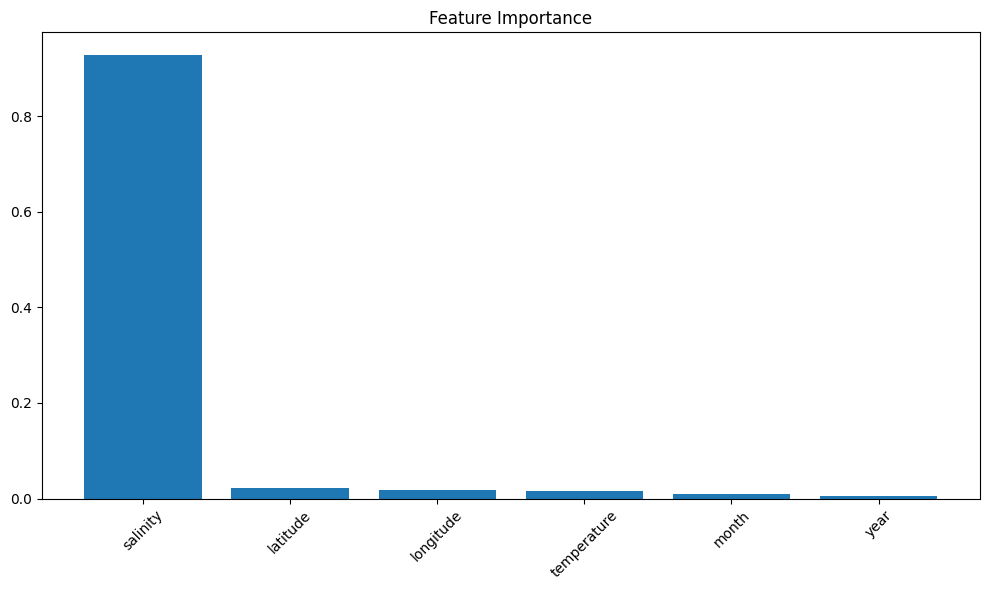

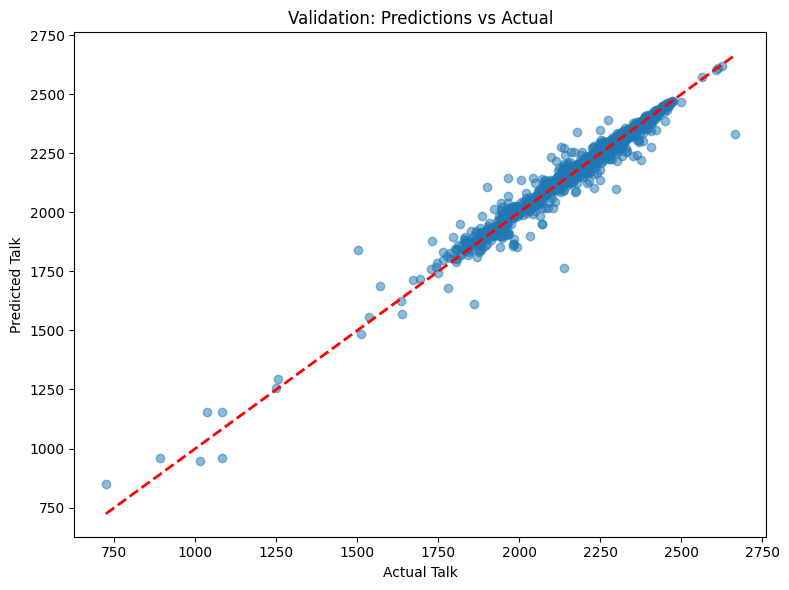


Preparing satellite data for prediction...
Required features: ['latitude', 'longitude', 'year', 'month', 'salinity', 'temperature']
Available features in satellite data: ['latitude', 'longitude', 'year', 'month', 'salinity', 'temperature']

Making predictions on satellite data...

Prediction statistics:
Mean predicted talk: 2221.1385
Std predicted talk: 212.2167
Min predicted talk: 721.9651
Max predicted talk: 2621.8970


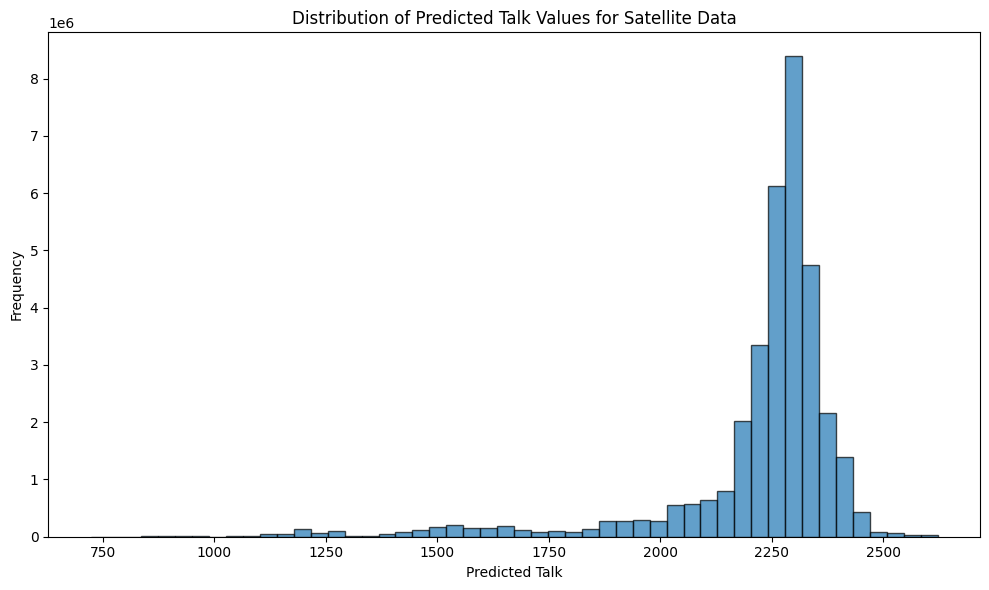


Predictions saved to 'satellite_talk_predictions.csv'
Output columns: ['time', 'latitude', 'longitude', 'sss', 'sst', 'year', 'month', 'predicted_talk', 'salinity', 'temperature']

Model training and prediction completed!


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def load_and_prepare_data(glodap_file, satellite_file):
    """
    Load and prepare GLODAP training data and satellite test data
    """
    # Load GLODAP dataset
    print("Loading GLODAP dataset...")
    glodap_data = pd.read_csv(glodap_file)

    # Load satellite dataset
    print("Loading satellite dataset...")
    satellite_data = pd.read_csv(satellite_file)

    print(f"GLODAP data shape: {glodap_data.shape}")
    print(f"Satellite data shape: {satellite_data.shape}")

    return glodap_data, satellite_data

def preprocess_glodap_data(glodap_data):
    """
    Preprocess GLODAP data for training
    """
    # Check for missing values
    print("\nMissing values in GLODAP data:")
    print(glodap_data.isnull().sum())

    # Remove rows with missing 'talk' values (target variable)
    glodap_clean = glodap_data.dropna(subset=['talk']).copy()

    # Handle missing values in features (fill with median)
    feature_columns = ['latitude', 'longitude', 'year', 'month',
                      'salinity', 'temperature']

    for col in feature_columns:
        if col in glodap_clean.columns:
            glodap_clean[col].fillna(glodap_clean[col].median(), inplace=True)

    print(f"Clean GLODAP data shape: {glodap_clean.shape}")

    return glodap_clean

def preprocess_satellite_data(satellite_data, glodap_data):
    """
    Preprocess satellite data for prediction
    """
    print("\nMissing values in satellite data:")
    print(satellite_data.isnull().sum())

    # Create a copy for preprocessing
    satellite_clean = satellite_data.copy()

    # Map satellite column names to GLODAP column names
    column_mapping = {
        'sss': 'salinity',    # Sea surface salinity -> salinity
        'sst': 'temperature'  # Sea surface temperature -> temperature
    }

    # Rename columns to match GLODAP naming
    satellite_clean = satellite_clean.rename(columns=column_mapping)

    # Handle missing values in satellite data
    available_columns = ['latitude', 'longitude', 'salinity', 'temperature', 'year', 'month']

    for col in available_columns:
        if col in satellite_clean.columns:
            satellite_clean[col].fillna(satellite_clean[col].median(), inplace=True)

    print(f"Clean satellite data shape: {satellite_clean.shape}")
    print(f"Satellite data columns after preprocessing: {satellite_clean.columns.tolist()}")

    return satellite_clean

def train_random_forest_model(X_train, y_train, X_val, y_val):
    """
    Train Random Forest model with hyperparameter tuning
    """
    print("\nTraining Random Forest model...")

    # Initialize Random Forest with good default parameters
    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions on validation set
    y_pred_val = rf_model.predict(X_val)

    # Calculate validation metrics
    mse_val = mean_squared_error(y_val, y_pred_val)
    rmse_val = np.sqrt(mse_val)
    mae_val = mean_absolute_error(y_val, y_pred_val)
    r2_val = r2_score(y_val, y_pred_val)

    print(f"Validation RMSE: {rmse_val:.4f}")
    print(f"Validation MAE: {mae_val:.4f}")
    print(f"Validation R²: {r2_val:.4f}")

    return rf_model

def plot_feature_importance(model, feature_names):
    """
    Plot feature importance
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
    plt.tight_layout()
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, title="Predictions vs Actual"):
    """
    Plot predictions vs actual values
    """
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Talk')
    plt.ylabel('Predicted Talk')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def main(glodap_file, satellite_file):
    """
    Main function to run the complete pipeline
    """
    # Load data
    glodap_data, satellite_data = load_and_prepare_data(glodap_file, satellite_file)

    # Display satellite data info
    print(f"\nSatellite data columns: {satellite_data.columns.tolist()}")
    print(f"Expected columns: ['time', 'latitude', 'longitude', 'sss', 'sst', 'year', 'month']")

    # Preprocess data
    glodap_clean = preprocess_glodap_data(glodap_data)
    satellite_clean = preprocess_satellite_data(satellite_data, glodap_clean)

    # Prepare features and target for GLODAP data
    feature_columns = ['latitude', 'longitude', 'year', 'month',
                      'salinity', 'temperature']

    X_glodap = glodap_clean[feature_columns]
    y_glodap = glodap_clean['talk']

    # Split GLODAP data for training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_glodap, y_glodap, test_size=0.2, random_state=42
    )

    print(f"\nTraining set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")

    # Optional: Scale features (Random Forest doesn't require scaling but can help)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    # Train model
    rf_model = train_random_forest_model(X_train, y_train, X_val, y_val)

    # Plot feature importance
    plot_feature_importance(rf_model, feature_columns)

    # Make predictions on validation set
    y_pred_val = rf_model.predict(X_val)
    plot_predictions_vs_actual(y_val, y_pred_val, "Validation: Predictions vs Actual")

    # Prepare satellite data for prediction (ensure all required features are present)
    print(f"\nPreparing satellite data for prediction...")
    print(f"Required features: {feature_columns}")
    print(f"Available features in satellite data: {[col for col in feature_columns if col in satellite_clean.columns]}")

    X_satellite = satellite_clean[feature_columns]

    # Make predictions on satellite data
    print("\nMaking predictions on satellite data...")
    talk_predictions = rf_model.predict(X_satellite)

    # Add predictions to satellite data (keeping original column names)
    satellite_results = satellite_data.copy()  # Use original satellite data
    satellite_results['predicted_talk'] = talk_predictions

    # Also add the mapped features for reference
    satellite_results['salinity'] = satellite_clean['salinity']
    satellite_results['temperature'] = satellite_clean['temperature']

    print(f"\nPrediction statistics:")
    print(f"Mean predicted talk: {talk_predictions.mean():.4f}")
    print(f"Std predicted talk: {talk_predictions.std():.4f}")
    print(f"Min predicted talk: {talk_predictions.min():.4f}")
    print(f"Max predicted talk: {talk_predictions.max():.4f}")

    # Plot prediction distribution
    plt.figure(figsize=(10, 6))
    plt.hist(talk_predictions, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Predicted Talk')
    plt.ylabel('Frequency')
    plt.title('Distribution of Predicted Talk Values for Satellite Data')
    plt.tight_layout()
    plt.show()

    # Save results
    satellite_results.to_csv('satellite_talk_predictions.csv', index=False)
    print("\nPredictions saved to 'satellite_talk_predictions.csv'")
    print(f"Output columns: {satellite_results.columns.tolist()}")

    return rf_model, satellite_results

# Example usage:
if __name__ == "__main__":
    # Replace with your actual file paths
    glodap_file = "/content/drive/MyDrive/for_train_2018filtered_data.csv"
    satellite_file = "/content/drive/MyDrive/imputed_Testing_on_satellite_data.csv"

    # Run the complete pipeline
    model, results = main(glodap_file, satellite_file)

    # Additional analysis can be done here
    print("\nModel training and prediction completed!")

# Additional utility function to handle satellite data column mapping
def verify_satellite_columns(satellite_data):
    """
    Verify and display information about satellite data columns
    """
    expected_columns = ['time', 'latitude', 'longitude', 'sss', 'sst', 'year', 'month']
    actual_columns = satellite_data.columns.tolist()

    print("=== Satellite Data Column Verification ===")
    print(f"Expected columns: {expected_columns}")
    print(f"Actual columns: {actual_columns}")

    missing_columns = [col for col in expected_columns if col not in actual_columns]
    extra_columns = [col for col in actual_columns if col not in expected_columns]

    if missing_columns:
        print(f"Missing columns: {missing_columns}")
    if extra_columns:
        print(f"Extra columns: {extra_columns}")

    # Show column mapping
    print("\nColumn mapping for prediction:")
    print("sss (Sea Surface Salinity) -> salinity")
    print("sst (Sea Surface Temperature) -> temperature")
    print("Missing features will be imputed from GLODAP medians:")
    print("- day, hour, depth, pressure")

    return True

def cross_validate_model(X, y, cv_folds=5):
    """
    Perform cross-validation on the model
    """
    from sklearn.model_selection import cross_val_score

    rf_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    )

    # Perform cross-validation
    cv_scores = cross_val_score(rf_model, X, y, cv=cv_folds,
                               scoring='neg_mean_squared_error', n_jobs=-1)

    rmse_scores = np.sqrt(-cv_scores)

    print(f"\nCross-validation results ({cv_folds}-fold):")
    print(f"RMSE scores: {rmse_scores}")
    print(f"Mean RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

    return rmse_scores

def analyze_predictions_by_region(satellite_results):
    """
    Analyze predictions by geographical regions
    """
    # Define regions based on latitude
    def classify_region(lat):
        if lat > 60:
            return 'Arctic'
        elif lat > 23.5:
            return 'Northern'
        elif lat > -23.5:
            return 'Tropical'
        elif lat > -60:
            return 'Southern'
        else:
            return 'Antarctic'

    satellite_results['region'] = satellite_results['latitude'].apply(classify_region)

    # Analyze by region
    regional_stats = satellite_results.groupby('region')['predicted_talk'].agg([
        'count', 'mean', 'std', 'min', 'max'
    ]).round(4)

    print("\nPredicted Talk statistics by region:")
    print(regional_stats)

    # Plot by region
    plt.figure(figsize=(12, 6))
    satellite_results.boxplot(column='predicted_talk', by='region', ax=plt.gca())
    plt.title('Predicted Talk Distribution by Region')
    plt.ylabel('Predicted Talk')
    plt.xlabel('Region')
    plt.tight_layout()
    plt.show()

    return regional_stats

In [ ]:
import pandas as pd
dfa=pd.read_csv('/content/satellite_talk_predictions.csv')

print("SSS vs Salinity identical:", dfa['sss'].equals(dfa['salinity']))
print("SST vs Temperature identical:", dfa['sst'].equals(dfa['temperature']))

SSS vs Salinity identical: True
SST vs Temperature identical: True




Bias: This tells you the average difference between your predicted values and the observed ground truth values (predicted_talk - glodap_talk).
A positive bias means your model, on average, overpredicts alkalinity compared to the ground truth.
A negative bias means your model, on average, underpredicts alkalinity.
A bias close to zero indicates that the model's predictions are centered around the true values.
RMSE (Root Mean Squared Error): This is a measure of the average magnitude of the errors. It's the square root of the average of the squared differences between predicted and observed values.
RMSE gives more weight to larger errors.
A lower RMSE indicates better model performance, meaning the predictions are closer to the actual values on average. The unit of RMSE is the same as the unit of your target variable (alkalinity).
MAE (Mean Absolute Error): This is the average of the absolute differences between predicted and observed values.
MAE is less sensitive to outliers than RMSE because it doesn't square the errors.
A lower MAE also indicates better model performance. The unit of MAE is also the same as the unit of your target variable.
R-squared (R²): This metric represents the proportion of the variance in the dependent variable (observed alkalinity) that is predictable from the independent variables (the features used for prediction).
R² ranges from 0 to 1 (or can be negative in some cases, indicating a very poor fit).
An R² of 1 means the model perfectly predicts the observed values.
An R² of 0 means the model does no better than simply predicting the mean of the observed values.
A higher R² indicates that your model explains a larger proportion of the variance in alkalinity and is a better fit for the data.
Now, let's look at the plots that were generated:

Scatter Plot (Predicted vs. Observed): This plot shows each match-up point with its observed GLODAP alkalinity on the x-axis and the model's predicted alkalinity on the y-axis.
The red dashed line represents the 1:1 line where predicted equals observed.
If your model were perfect, all the points would fall exactly on this line.
Points scattered closely around the 1:1 line indicate good predictions. Points far away from the line represent larger errors.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr, spearmanr
import warnings
warnings.filterwarnings('ignore')

def load_validation_data(satellite_predictions_file, glodap_ground_truth_file):
    """
    Load satellite predictions and GLODAP ground truth data for validation
    """
    print("Loading satellite predictions...")
    satellite_preds = pd.read_csv(satellite_predictions_file)

    print("Loading GLODAP ground truth data (2019-2021)...")
    glodap_truth = pd.read_csv(glodap_ground_truth_file)

    # Filter GLODAP data for validation years (2019-2021)
    glodap_truth = glodap_truth[
        (glodap_truth['year'] >= 2019) &
        (glodap_truth['year'] <= 2021)
    ].copy()

    print(f"Satellite predictions shape: {satellite_preds.shape}")
    print(f"GLODAP ground truth shape (2019-2021): {glodap_truth.shape}")

    # Display column information
    print(f"\nSatellite predictions columns: {satellite_preds.columns.tolist()}")
    print(f"GLODAP ground truth columns: {glodap_truth.columns.tolist()}")

    return satellite_preds, glodap_truth

def spatial_temporal_matching(satellite_preds, glodap_truth,
                             spatial_threshold=1.0, temporal_threshold=30):
    """
    Match satellite predictions with GLODAP ground truth based on
    spatial and temporal proximity

    Parameters:
    - spatial_threshold: degrees (latitude/longitude)
    - temporal_threshold: days
    """
    print(f"\nMatching data points...")
    print(f"Spatial threshold: {spatial_threshold}° (lat/lon)")
    print(f"Temporal threshold: {temporal_threshold} days")

    matched_data = []

    # Convert time to datetime if needed
    if 'time' in satellite_preds.columns:
        satellite_preds['datetime'] = pd.to_datetime(satellite_preds['time'])
    else:
        # Create datetime from year and month
        satellite_preds['datetime'] = pd.to_datetime(
            satellite_preds[['year', 'month']].assign(day=15)
        )

    # Create datetime for GLODAP data
    if 'day' in glodap_truth.columns:
        glodap_truth['datetime'] = pd.to_datetime(
            glodap_truth[['year', 'month', 'day']]
        )
    else:
        glodap_truth['datetime'] = pd.to_datetime(
            glodap_truth[['year', 'month']].assign(day=15)
        )

    print("Finding matches...")

    for idx, sat_row in satellite_preds.iterrows():
        if idx % 1000 == 0:
            print(f"Processed {idx}/{len(satellite_preds)} satellite points...")

        # Calculate spatial distances
        lat_diff = np.abs(glodap_truth['latitude'] - sat_row['latitude'])
        lon_diff = np.abs(glodap_truth['longitude'] - sat_row['longitude'])

        # Handle longitude wrapping (for points crossing 180/-180)
        lon_diff = np.minimum(lon_diff, 360 - lon_diff)

        spatial_distance = np.sqrt(lat_diff**2 + lon_diff**2)

        # Calculate temporal distances (in days)
        temporal_distance = np.abs(
            (glodap_truth['datetime'] - sat_row['datetime']).dt.days
        )

        # Find matches within thresholds
        spatial_mask = spatial_distance <= spatial_threshold
        temporal_mask = temporal_distance <= temporal_threshold
        combined_mask = spatial_mask & temporal_mask

        if combined_mask.any():
            # Find the closest match (prioritize spatial proximity)
            matches = glodap_truth[combined_mask].copy()
            matches['total_distance'] = (
                spatial_distance[combined_mask] +
                temporal_distance[combined_mask] / 30.0  # Normalize temporal distance
            )

            closest_match = matches.loc[matches['total_distance'].idxmin()]

            # Store matched pair
            matched_data.append({
                'satellite_lat': sat_row['latitude'],
                'satellite_lon': sat_row['longitude'],
                'satellite_year': sat_row['year'],
                'satellite_month': sat_row['month'],
                'satellite_datetime': sat_row['datetime'],
                'predicted_talk': sat_row['predicted_talk'],
                'satellite_sss': sat_row['sss'],
                'satellite_sst': sat_row['sst'],
                'glodap_lat': closest_match['latitude'],
                'glodap_lon': closest_match['longitude'],
                'glodap_year': closest_match['year'],
                'glodap_month': closest_match['month'],
                'glodap_datetime': closest_match['datetime'],
                'actual_talk': closest_match['talk'],
                'glodap_salinity': closest_match['salinity'],
                'glodap_temperature': closest_match['temperature'],
                'spatial_distance': spatial_distance[closest_match.name],
                'temporal_distance': temporal_distance[closest_match.name]
            })

    matched_df = pd.DataFrame(matched_data)

    print(f"\nMatching results:")
    print(f"Total satellite predictions: {len(satellite_preds)}")
    print(f"Total GLODAP ground truth points: {len(glodap_truth)}")
    print(f"Successfully matched pairs: {len(matched_df)}")
    print(f"Matching rate: {len(matched_df)/len(satellite_preds)*100:.2f}%")

    if len(matched_df) > 0:
        print(f"Average spatial distance: {matched_df['spatial_distance'].mean():.3f}°")
        print(f"Average temporal distance: {matched_df['temporal_distance'].mean():.1f} days")

    return matched_df

def calculate_validation_metrics(matched_df):
    """
    Calculate comprehensive validation metrics
    """
    if len(matched_df) == 0:
        print("No matched data points found for validation!")
        return None

    y_true = matched_df['actual_talk']
    y_pred = matched_df['predicted_talk']

    # Basic regression metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    # Additional metrics
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error

    # Correlation metrics
    pearson_r, pearson_p = pearsonr(y_true, y_pred)
    spearman_r, spearman_p = spearmanr(y_true, y_pred)

    # Bias metrics
    bias = np.mean(y_pred - y_true)
    relative_bias = bias / np.mean(y_true) * 100

    metrics = {
        'n_samples': len(matched_df),
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'mape': mape,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'bias': bias,
        'relative_bias': relative_bias,
        'actual_mean': np.mean(y_true),
        'actual_std': np.std(y_true),
        'predicted_mean': np.mean(y_pred),
        'predicted_std': np.std(y_pred)
    }

    print("\n" + "="*50)
    print("VALIDATION METRICS")
    print("="*50)
    print(f"Number of matched samples: {metrics['n_samples']}")
    print(f"Root Mean Square Error (RMSE): {metrics['rmse']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {metrics['mape']:.2f}%")
    print(f"Pearson Correlation: {metrics['pearson_r']:.4f} (p={metrics['pearson_p']:.4e})")
    print(f"Spearman Correlation: {metrics['spearman_r']:.4f} (p={metrics['spearman_p']:.4e})")
    print(f"Bias: {metrics['bias']:.4f}")
    print(f"Relative Bias: {metrics['relative_bias']:.2f}%")
    print(f"\nActual Talk - Mean: {metrics['actual_mean']:.4f}, Std: {metrics['actual_std']:.4f}")
    print(f"Predicted Talk - Mean: {metrics['predicted_mean']:.4f}, Std: {metrics['predicted_std']:.4f}")

    return metrics

def create_validation_plots(matched_df, metrics):
    """
    Create comprehensive validation plots
    """
    if len(matched_df) == 0:
        print("No data to plot!")
        return

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Satellite Predictions Validation Analysis', fontsize=16)

    y_true = matched_df['actual_talk']
    y_pred = matched_df['predicted_talk']

    # 1. Scatter plot: Predictions vs Actual
    axes[0, 0].scatter(y_true, y_pred, alpha=0.6, color='blue', s=20)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual Talk')
    axes[0, 0].set_ylabel('Predicted Talk')
    axes[0, 0].set_title(f'Predictions vs Actual\n(R² = {metrics["r2"]:.3f}, RMSE = {metrics["rmse"]:.3f})')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Residuals plot
    residuals = y_pred - y_true
    axes[0, 1].scatter(y_pred, residuals, alpha=0.6, color='green', s=20)
    axes[0, 1].axhline(y=0, color='r', linestyle='--', lw=2)
    axes[0, 1].set_xlabel('Predicted Talk')
    axes[0, 1].set_ylabel('Residuals (Predicted - Actual)')
    axes[0, 1].set_title(f'Residuals Plot\n(Bias = {metrics["bias"]:.3f})')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Histogram of residuals
    axes[0, 2].hist(residuals, bins=30, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(x=0, color='r', linestyle='--', lw=2)
    axes[0, 2].set_xlabel('Residuals')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Residuals')
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Spatial distribution of errors
    spatial_errors = np.abs(residuals)
    scatter = axes[1, 0].scatter(matched_df['satellite_lon'], matched_df['satellite_lat'],
                                c=spatial_errors, cmap='YlOrRd', s=30, alpha=0.7)
    axes[1, 0].set_xlabel('Longitude')
    axes[1, 0].set_ylabel('Latitude')
    axes[1, 0].set_title('Spatial Distribution of Absolute Errors')
    plt.colorbar(scatter, ax=axes[1, 0], label='Absolute Error')

    # 5. Temporal analysis
    if 'satellite_year' in matched_df.columns:
        temporal_stats = matched_df.groupby(['satellite_year', 'satellite_month']).agg({
            'predicted_talk': 'mean',
            'actual_talk': 'mean'
        }).reset_index()
        temporal_stats['date'] = pd.to_datetime(temporal_stats[['satellite_year', 'satellite_month']].assign(day=1))

        axes[1, 1].plot(temporal_stats['date'], temporal_stats['actual_talk'], 'o-', label='Actual', color='blue')
        axes[1, 1].plot(temporal_stats['date'], temporal_stats['predicted_talk'], 'o-', label='Predicted', color='red')
        axes[1, 1].set_xlabel('Date')
        axes[1, 1].set_ylabel('Mean Talk')
        axes[1, 1].set_title('Temporal Comparison')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].tick_params(axis='x', rotation=45)

    # 6. Error statistics by region
    def classify_region(lat):
        if lat > 60:
            return 'Arctic'
        elif lat > 23.5:
            return 'Northern'
        elif lat > -23.5:
            return 'Tropical'
        elif lat > -60:
            return 'Southern'
        else:
            return 'Antarctic'

    matched_df['region'] = matched_df['satellite_lat'].apply(classify_region)
    regional_errors = matched_df.groupby('region')['predicted_talk'].apply(
        lambda x: np.sqrt(mean_squared_error(matched_df.loc[x.index, 'actual_talk'], x))
    )

    regional_errors.plot(kind='bar', ax=axes[1, 2], color='orange', alpha=0.7)
    axes[1, 2].set_xlabel('Region')
    axes[1, 2].set_ylabel('RMSE')
    axes[1, 2].set_title('RMSE by Region')
    axes[1, 2].tick_params(axis='x', rotation=45)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def analyze_error_patterns(matched_df):
    """
    Analyze patterns in prediction errors
    """
    if len(matched_df) == 0:
        return

    print("\n" + "="*50)
    print("ERROR PATTERN ANALYSIS")
    print("="*50)

    residuals = matched_df['predicted_talk'] - matched_df['actual_talk']
    abs_errors = np.abs(residuals)

    # Error statistics
    print(f"Error Statistics:")
    print(f"  Mean absolute error: {abs_errors.mean():.4f}")
    print(f"  Median absolute error: {abs_errors.median():.4f}")
    print(f"  90th percentile error: {abs_errors.quantile(0.9):.4f}")
    print(f"  95th percentile error: {abs_errors.quantile(0.95):.4f}")
    print(f"  Maximum error: {abs_errors.max():.4f}")

    # Regional analysis
    matched_df['region'] = matched_df['satellite_lat'].apply(
        lambda lat: 'Arctic' if lat > 60 else 'Northern' if lat > 23.5 else
                   'Tropical' if lat > -23.5 else 'Southern' if lat > -60 else 'Antarctic'
    )

    regional_stats = matched_df.groupby('region').agg({
        'predicted_talk': ['count', 'mean'],
        'actual_talk': 'mean'
    }).round(4)
    regional_stats.columns = ['Count', 'Pred_Mean', 'Actual_Mean']
    regional_errors = matched_df.groupby('region').apply(
        lambda x: np.sqrt(mean_squared_error(x['actual_talk'], x['predicted_talk']))
    ).round(4)
    regional_stats['RMSE'] = regional_errors

    print(f"\nRegional Analysis:")
    print(regional_stats)

    # Seasonal analysis
    seasonal_stats = matched_df.groupby('satellite_month').agg({
        'predicted_talk': ['count', 'mean'],
        'actual_talk': 'mean'
    }).round(4)
    seasonal_stats.columns = ['Count', 'Pred_Mean', 'Actual_Mean']
    seasonal_errors = matched_df.groupby('satellite_month').apply(
        lambda x: np.sqrt(mean_squared_error(x['actual_talk'], x['predicted_talk']))
    ).round(4)
    seasonal_stats['RMSE'] = seasonal_errors

    print(f"\nSeasonal Analysis:")
    print(seasonal_stats)

def main_validation(satellite_predictions_file, glodap_ground_truth_file,
                   spatial_threshold=1.0, temporal_threshold=30):
    """
    Main validation function
    """
    print("Starting validation process...")

    # Load data
    satellite_preds, glodap_truth = load_validation_data(
        satellite_predictions_file, glodap_ground_truth_file
    )

    # Match satellite predictions with ground truth
    matched_df = spatial_temporal_matching(
        satellite_preds, glodap_truth,
        spatial_threshold=spatial_threshold,
        temporal_threshold=temporal_threshold
    )

    if len(matched_df) == 0:
        print("No matches found! Consider increasing thresholds.")
        return None, None

    # Calculate validation metrics
    metrics = calculate_validation_metrics(matched_df)

    # Create validation plots
    create_validation_plots(matched_df, metrics)

    # Analyze error patterns
    analyze_error_patterns(matched_df)

    # Save results
    matched_df.to_csv('validation_results.csv', index=False)
    print(f"\nValidation results saved to 'validation_results.csv'")

    # Save metrics
    metrics_df = pd.DataFrame([metrics])
    metrics_df.to_csv('validation_metrics.csv', index=False)
    print(f"Validation metrics saved to 'validation_metrics.csv'")

    return matched_df, metrics

# Example usage:
if __name__ == "__main__":
    # File paths - replace with your actual file paths
    satellite_predictions_file = "/content/satellite_talk_predictions.csv"
    glodap_ground_truth_file = "/content/drive/MyDrive/for_glodap_validation.csv"  # Your GLODAP 2019-2021 data

    # Run validation with different matching thresholds if needed
    print("Running validation with default thresholds (1.0° spatial, 30 days temporal)...")
    matched_data, validation_metrics = main_validation(
        satellite_predictions_file,
        glodap_ground_truth_file,
        spatial_threshold=1.0,  # degrees
        temporal_threshold=30   # days
    )

    # Optional: Try with different thresholds
    print("\n" + "="*60)
    print("Trying validation with relaxed thresholds (2.0° spatial, 60 days temporal)...")
    matched_data_relaxed, validation_metrics_relaxed = main_validation(
        satellite_predictions_file,
        glodap_ground_truth_file,
        spatial_threshold=2.0,  # degrees
        temporal_threshold=60   # days
    )

    print("\nValidation completed!")
    print("Check the generated plots and CSV files for detailed results.")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

def load_data(prediction_file="/content/satellite_talk_predictions.csv", ground_truth_file="/content/drive/MyDrive/for_glodap_validation.csv"):
    """
    Load prediction and ground truth datasets efficiently
    """
    print("Loading datasets...")

    try:
        predictions = pd.read_csv(prediction_file)
        ground_truth = pd.read_csv(ground_truth_file)

        print(f"Predictions shape: {predictions.shape}")
        print(f"Ground truth shape: {ground_truth.shape}")

        print(f"Prediction columns: {list(predictions.columns)}")
        print(f"Ground truth columns: {list(ground_truth.columns)}")

        return predictions, ground_truth

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Make sure files 'prediction.csv' and 'tr.csv' exist in the current directory")
        return None, None

def fast_spatial_matching(predictions, ground_truth, max_distance=1.0):
    """
    Fast spatial matching using KD-tree for efficient nearest neighbor search
    """
    print(f"Performing fast spatial matching with max distance: {max_distance}°")

    # Prepare coordinates
    pred_coords = predictions[['latitude', 'longitude']].values
    truth_coords = ground_truth[['latitude', 'longitude']].values

    # Use KD-tree for fast nearest neighbor search
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='haversine')
    nbrs.fit(np.radians(truth_coords))

    # Find nearest neighbors
    distances, indices = nbrs.kneighbors(np.radians(pred_coords))

    # Convert distances from radians to degrees (approximate)
    distances_deg = np.degrees(distances.flatten()) * 111  # km to degrees approximation

    # Filter matches within threshold
    valid_matches = distances_deg <= (max_distance * 111)  # convert degrees to km

    print(f"Found {valid_matches.sum()} matches out of {len(predictions)} predictions")
    print(f"Matching rate: {valid_matches.sum()/len(predictions)*100:.2f}%")

    if valid_matches.sum() == 0:
        print("No matches found! Try increasing max_distance parameter")
        return pd.DataFrame()

    # Create matched dataset
    matched_indices = indices.flatten()[valid_matches]
    pred_indices = np.where(valid_matches)[0]

    matched_data = pd.DataFrame({
        'pred_lat': predictions.iloc[pred_indices]['latitude'].values,
        'pred_lon': predictions.iloc[pred_indices]['longitude'].values,
        'truth_lat': ground_truth.iloc[matched_indices]['latitude'].values,
        'truth_lon': ground_truth.iloc[matched_indices]['longitude'].values,
        'predicted_talk': predictions.iloc[pred_indices]['predicted_talk'].values if 'predicted_talk' in predictions.columns
                         else predictions.iloc[pred_indices]['talk'].values,
        'actual_talk': ground_truth.iloc[matched_indices]['talk'].values,
        'distance_km': distances_deg[valid_matches]
    })

    # Add additional features if available
    for col in ['sst', 'sss', 'year', 'month']:
        if col in predictions.columns:
            matched_data[f'pred_{col}'] = predictions.iloc[pred_indices][col].values
        if col in ground_truth.columns:
            matched_data[f'truth_{col}'] = ground_truth.iloc[matched_indices][col].values

    print(f"Average matching distance: {matched_data['distance_km'].mean():.2f} km")

    return matched_data

def calculate_comprehensive_metrics(matched_df):
    """
    Calculate comprehensive validation metrics efficiently
    """
    if len(matched_df) == 0:
        print("No matched data for validation!")
        return None

    y_true = matched_df['actual_talk'].values
    y_pred = matched_df['predicted_talk'].values

    # Remove any NaN values
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]

    if len(y_true) == 0:
        print("No valid data points after removing NaN values!")
        return None

    # Calculate metrics
    metrics = {
        'n_samples': len(y_true),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100,
        'bias': np.mean(y_pred - y_true),
        'relative_bias': np.mean(y_pred - y_true) / np.mean(y_true) * 100,
        'pearson_r': pearsonr(y_true, y_pred)[0],
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_r': spearmanr(y_true, y_pred)[0],
        'actual_mean': np.mean(y_true),
        'actual_std': np.std(y_true),
        'predicted_mean': np.mean(y_pred),
        'predicted_std': np.std(y_pred),
        'actual_range': [np.min(y_true), np.max(y_true)],
        'predicted_range': [np.min(y_pred), np.max(y_pred)]
    }

    # Print results
    print("\n" + "="*60)
    print("GLOBAL VALIDATION METRICS")
    print("="*60)
    print(f"Number of matched samples: {metrics['n_samples']:,}")
    print(f"Root Mean Square Error (RMSE): {metrics['rmse']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"Mean Absolute Percentage Error: {metrics['mape']:.2f}%")
    print(f"Bias: {metrics['bias']:.4f}")
    print(f"Relative Bias: {metrics['relative_bias']:.2f}%")
    print(f"Pearson Correlation: {metrics['pearson_r']:.4f} (p={metrics['pearson_p']:.2e})")
    print(f"Spearman Correlation: {metrics['spearman_r']:.4f}")
    print(f"\nData Ranges:")
    print(f"  Actual: [{metrics['actual_range'][0]:.4f}, {metrics['actual_range'][1]:.4f}]")
    print(f"  Predicted: [{metrics['predicted_range'][0]:.4f}, {metrics['predicted_range'][1]:.4f}]")
    print(f"  Actual Mean ± Std: {metrics['actual_mean']:.4f} ± {metrics['actual_std']:.4f}")
    print(f"  Predicted Mean ± Std: {metrics['predicted_mean']:.4f} ± {metrics['predicted_std']:.4f}")

    return metrics

def create_validation_plots(matched_df, metrics, save_plots=True):
    """
    Create comprehensive validation plots
    """
    if len(matched_df) == 0:
        print("No data available for plotting!")
        return

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Global Model Validation Results', fontsize=16, fontweight='bold')

    y_true = matched_df['actual_talk'].values
    y_pred = matched_df['predicted_talk'].values

    # Remove NaN values for plotting
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    residuals = y_pred - y_true

    # 1. Prediction vs Actual scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5, s=15, color='steelblue')
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual Talk')
    axes[0, 0].set_ylabel('Predicted Talk')
    axes[0, 0].set_title(f'Predictions vs Actual\nR² = {metrics["r2"]:.3f}, RMSE = {metrics["rmse"]:.3f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Residuals plot
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=15, color='green')
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Predicted Talk')
    axes[0, 1].set_ylabel('Residuals (Predicted - Actual)')
    axes[0, 1].set_title(f'Residuals Plot\nBias = {metrics["bias"]:.4f}')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Residuals histogram
    axes[0, 2].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].axvline(x=np.mean(residuals), color='orange', linestyle='-', linewidth=2, label=f'Mean = {np.mean(residuals):.3f}')
    axes[0, 2].set_xlabel('Residuals')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Residuals')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Spatial distribution of predictions
    if 'pred_lat' in matched_df.columns and 'pred_lon' in matched_df.columns:
        scatter = axes[1, 0].scatter(matched_df['pred_lon'], matched_df['pred_lat'],
                                   c=matched_df['predicted_talk'], cmap='viridis', s=20, alpha=0.7)
        axes[1, 0].set_xlabel('Longitude')
        axes[1, 0].set_ylabel('Latitude')
        axes[1, 0].set_title('Spatial Distribution of Predictions')
        plt.colorbar(scatter, ax=axes[1, 0], label='Predicted Talk')

    # 5. Error spatial distribution
    if 'pred_lat' in matched_df.columns and 'pred_lon' in matched_df.columns:
        abs_errors = np.abs(residuals)
        scatter = axes[1, 1].scatter(matched_df.loc[valid_mask, 'pred_lon'], matched_df.loc[valid_mask, 'pred_lat'],
                                   c=abs_errors, cmap='Reds', s=20, alpha=0.7)
        axes[1, 1].set_xlabel('Longitude')
        axes[1, 1].set_ylabel('Latitude')
        axes[1, 1].set_title('Spatial Distribution of Absolute Errors')
        plt.colorbar(scatter, ax=axes[1, 1], label='Absolute Error')

    # 6. Q-Q plot for residuals normality
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot (Residuals Normality)')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig('global_validation_plots.png', dpi=300, bbox_inches='tight')
        print("Plots saved as 'global_validation_plots.png'")

    plt.show()

def quick_stats_summary(matched_df):
    """
    Print quick statistical summary
    """
    if len(matched_df) == 0:
        return

    print("\n" + "="*60)
    print("QUICK STATISTICAL SUMMARY")
    print("="*60)

    # Basic statistics
    print("Dataset Summary:")
    print(f"  Total matched pairs: {len(matched_df):,}")
    print(f"  Average matching distance: {matched_df['distance_km'].mean():.2f} km")
    print(f"  Maximum matching distance: {matched_df['distance_km'].max():.2f} km")

    # Value ranges and distributions
    actual = matched_df['actual_talk']
    predicted = matched_df['predicted_talk']

    print(f"\nValue Distributions:")
    print(f"  Actual Talk: {actual.min():.4f} to {actual.max():.4f} (mean: {actual.mean():.4f})")
    print(f"  Predicted Talk: {predicted.min():.4f} to {predicted.max():.4f} (mean: {predicted.mean():.4f})")

    # Outlier analysis
    residuals = predicted - actual
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    outlier_threshold = 1.5 * iqr
    outliers = np.sum(np.abs(residuals - np.median(residuals)) > outlier_threshold)

    print(f"\nOutlier Analysis:")
    print(f"  Number of potential outliers: {outliers} ({outliers/len(matched_df)*100:.1f}%)")
    print(f"  95th percentile absolute error: {np.percentile(np.abs(residuals), 95):.4f}")

def main_validation(prediction_file="/content/satellite_talk_predictions.csv", ground_truth_file="/content/drive/MyDrive/for_glodap_validation.csv",
                   max_distance=1.0, save_results=True):
    """
    Main fast validation function
    """
    print("Starting fast global validation...")
    print(f"Prediction file: {prediction_file}")
    print(f"Ground truth file: {ground_truth_file}")
    print(f"Maximum matching distance: {max_distance}°")

    # Load data
    predictions, ground_truth = load_data(prediction_file, ground_truth_file)
    if predictions is None or ground_truth is None:
        return None, None

    # Fast spatial matching
    matched_df = fast_spatial_matching(predictions, ground_truth, max_distance)
    if len(matched_df) == 0:
        print("No matches found! Try increasing max_distance parameter.")
        return None, None

    # Calculate metrics
    metrics = calculate_comprehensive_metrics(matched_df)
    if metrics is None:
        return None, None

    # Quick statistics
    quick_stats_summary(matched_df)

    # Create plots
    create_validation_plots(matched_df, metrics, save_plots=save_results)

    # Save results
    if save_results:
        matched_df.to_csv('global_validation_results.csv', index=False)

        # Save metrics as a readable report
        with open('validation_report.txt', 'w') as f:
            f.write("GLOBAL MODEL VALIDATION REPORT\n")
            f.write("="*50 + "\n\n")
            f.write(f"Dataset Information:\n")
            f.write(f"  Matched samples: {metrics['n_samples']:,}\n")
            f.write(f"  Matching distance threshold: {max_distance}°\n\n")
            f.write(f"Performance Metrics:\n")
            f.write(f"  RMSE: {metrics['rmse']:.4f}\n")
            f.write(f"  MAE: {metrics['mae']:.4f}\n")
            f.write(f"  R²: {metrics['r2']:.4f}\n")
            f.write(f"  MAPE: {metrics['mape']:.2f}%\n")
            f.write(f"  Bias: {metrics['bias']:.4f}\n")
            f.write(f"  Relative Bias: {metrics['relative_bias']:.2f}%\n")
            f.write(f"  Pearson Correlation: {metrics['pearson_r']:.4f}\n")

        print(f"\nResults saved:")
        print(f"  - Matched data: 'global_validation_results.csv'")
        print(f"  - Validation report: 'validation_report.txt'")
        print(f"  - Plots: 'global_validation_plots.png'")

    return matched_df, metrics

# Quick execution examples
if __name__ == "__main__":
    print("="*60)
    print("FAST GLOBAL MODEL VALIDATION")
    print("="*60)

    # Run with default settings
    print("\n1. Running validation with 1.0° matching threshold...")
    matched_data, validation_metrics = main_validation(
        prediction_file="prediction.csv",
        ground_truth_file="tr.csv",
        max_distance=1.0,
        save_results=True
    )

    # Optional: Try with relaxed threshold if not enough matches
    if matched_data is not None and len(matched_data) < 1000:
        print("\n2. Trying with relaxed 2.0° matching threshold...")
        matched_data_relaxed, metrics_relaxed = main_validation(
            prediction_file="prediction.csv",
            ground_truth_file="tr.csv",
            max_distance=2.0,
            save_results=False
        )

    print("\n" + "="*60)
    print("VALIDATION COMPLETED!")
    print("="*60)

    if matched_data is not None:
        print(f"✓ Successfully validated with {len(matched_data):,} matched pairs")
        print(f"✓ Model R² Score: {validation_metrics['r2']:.4f}")
        print(f"✓ Model RMSE: {validation_metrics['rmse']:.4f}")
        print("✓ Check generated files for detailed results")
    else:
        print("✗ Validation failed - check your input files")

FAST GLOBAL MODEL VALIDATION

1. Running validation with 1.0° matching threshold...
Starting fast global validation...
Prediction file: prediction.csv
Ground truth file: tr.csv
Maximum matching distance: 1.0°
Loading datasets...
Error loading data: [Errno 2] No such file or directory: 'prediction.csv'
Make sure files 'prediction.csv' and 'tr.csv' exist in the current directory

VALIDATION COMPLETED!
✗ Validation failed - check your input files


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

def load_data(prediction_file="satellite_talk_predictions.csv", ground_truth_file="for_glodap_validation.csv"):
    """
    Load prediction and ground truth datasets efficiently
    """
    print("Loading datasets...")

    try:
        predictions = pd.read_csv(prediction_file)
        ground_truth = pd.read_csv(ground_truth_file)

        print(f"Predictions shape: {predictions.shape}")
        print(f"Ground truth shape: {ground_truth.shape}")

        print(f"Prediction columns: {list(predictions.columns)}")
        print(f"Ground truth columns: {list(ground_truth.columns)}")

        return predictions, ground_truth

    except Exception as e:
        print(f"Error loading data: {e}")
        print(f"Looking for files: '{prediction_file}' and '{ground_truth_file}'")
        print("Please make sure these files exist in the current directory")
        return None, None

def fast_spatial_matching(predictions, ground_truth, max_distance=1.0):
    """
    Fast spatial matching using KD-tree for efficient nearest neighbor search
    """
    print(f"Performing fast spatial matching with max distance: {max_distance}°")

    # Check for required columns and try different column names
    lat_cols = ['latitude', 'lat', 'Latitude', 'LAT']
    lon_cols = ['longitude', 'lon', 'Longitude', 'LON']
    talk_cols = ['predicted_talk', 'talk', 'Talk', 'TALK', 'prediction']

    # Find latitude column
    pred_lat_col = None
    for col in lat_cols:
        if col in predictions.columns:
            pred_lat_col = col
            break

    # Find longitude column
    pred_lon_col = None
    for col in lon_cols:
        if col in predictions.columns:
            pred_lon_col = col
            break

    # Find talk columns in ground truth
    truth_lat_col = None
    for col in lat_cols:
        if col in ground_truth.columns:
            truth_lat_col = col
            break

    truth_lon_col = None
    for col in lon_cols:
        if col in ground_truth.columns:
            truth_lon_col = col
            break

    # Find predicted talk column
    pred_talk_col = None
    for col in talk_cols:
        if col in predictions.columns:
            pred_talk_col = col
            break

    # Find actual talk column
    actual_talk_col = None
    for col in talk_cols:
        if col in ground_truth.columns:
            actual_talk_col = col
            break

    if not all([pred_lat_col, pred_lon_col, truth_lat_col, truth_lon_col, pred_talk_col, actual_talk_col]):
        print("Error: Could not find required columns in the datasets")
        print(f"Predictions columns: {list(predictions.columns)}")
        print(f"Ground truth columns: {list(ground_truth.columns)}")
        print(f"Looking for: latitude, longitude, and talk columns")
        return pd.DataFrame()

    print(f"Using columns - Pred: {pred_lat_col}, {pred_lon_col}, {pred_talk_col}")
    print(f"Using columns - Truth: {truth_lat_col}, {truth_lon_col}, {actual_talk_col}")

    # Prepare coordinates
    pred_coords = predictions[[pred_lat_col, pred_lon_col]].values
    truth_coords = ground_truth[[truth_lat_col, truth_lon_col]].values

    # Remove any NaN coordinates
    pred_valid = ~(np.isnan(pred_coords).any(axis=1))
    truth_valid = ~(np.isnan(truth_coords).any(axis=1))

    pred_coords = pred_coords[pred_valid]
    truth_coords = truth_coords[truth_valid]
    pred_indices_valid = np.where(pred_valid)[0]
    truth_indices_valid = np.where(truth_valid)[0]

    print(f"Valid prediction coordinates: {len(pred_coords)}")
    print(f"Valid ground truth coordinates: {len(truth_coords)}")

    if len(pred_coords) == 0 or len(truth_coords) == 0:
        print("No valid coordinates found!")
        return pd.DataFrame()

    # Use KD-tree for fast nearest neighbor search
    nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree', metric='haversine')
    nbrs.fit(np.radians(truth_coords))

    # Find nearest neighbors
    distances, indices = nbrs.kneighbors(np.radians(pred_coords))

    # Convert distances from radians to degrees (approximate)
    distances_deg = np.degrees(distances.flatten()) * 111  # km to degrees approximation

    # Filter matches within threshold
    valid_matches = distances_deg <= (max_distance * 111)  # convert degrees to km

    print(f"Found {valid_matches.sum()} matches out of {len(pred_coords)} predictions")
    print(f"Matching rate: {valid_matches.sum()/len(pred_coords)*100:.2f}%")

    if valid_matches.sum() == 0:
        print("No matches found! Try increasing max_distance parameter")
        return pd.DataFrame()

    # Create matched dataset
    matched_truth_indices = truth_indices_valid[indices.flatten()[valid_matches]]
    matched_pred_indices = pred_indices_valid[np.where(valid_matches)[0]]

    matched_data = pd.DataFrame({
        'pred_lat': predictions.iloc[matched_pred_indices][pred_lat_col].values,
        'pred_lon': predictions.iloc[matched_pred_indices][pred_lon_col].values,
        'truth_lat': ground_truth.iloc[matched_truth_indices][truth_lat_col].values,
        'truth_lon': ground_truth.iloc[matched_truth_indices][truth_lon_col].values,
        'predicted_talk': predictions.iloc[matched_pred_indices][pred_talk_col].values,
        'actual_talk': ground_truth.iloc[matched_truth_indices][actual_talk_col].values,
        'distance_km': distances_deg[valid_matches]
    })

    # Add additional features if available
    additional_cols = ['sst', 'sss', 'year', 'month', 'depth']
    for col in additional_cols:
        if col in predictions.columns:
            matched_data[f'pred_{col}'] = predictions.iloc[matched_pred_indices][col].values
        if col in ground_truth.columns:
            matched_data[f'truth_{col}'] = ground_truth.iloc[matched_truth_indices][col].values

    print(f"Average matching distance: {matched_data['distance_km'].mean():.2f} km")

    return matched_data

def calculate_comprehensive_metrics(matched_df):
    """
    Calculate comprehensive validation metrics efficiently
    """
    if len(matched_df) == 0:
        print("No matched data for validation!")
        return None

    y_true = matched_df['actual_talk'].values
    y_pred = matched_df['predicted_talk'].values

    # Remove any NaN values
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]

    if len(y_true) == 0:
        print("No valid data points after removing NaN values!")
        return None

    # Calculate metrics
    metrics = {
        'n_samples': len(y_true),
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / np.maximum(np.abs(y_true), 1e-8))) * 100,
        'bias': np.mean(y_pred - y_true),
        'relative_bias': np.mean(y_pred - y_true) / np.mean(y_true) * 100,
        'pearson_r': pearsonr(y_true, y_pred)[0],
        'pearson_p': pearsonr(y_true, y_pred)[1],
        'spearman_r': spearmanr(y_true, y_pred)[0],
        'actual_mean': np.mean(y_true),
        'actual_std': np.std(y_true),
        'predicted_mean': np.mean(y_pred),
        'predicted_std': np.std(y_pred),
        'actual_range': [np.min(y_true), np.max(y_true)],
        'predicted_range': [np.min(y_pred), np.max(y_pred)]
    }

    # Print results
    print("\n" + "="*60)
    print("GLOBAL VALIDATION METRICS")
    print("="*60)
    print(f"Number of matched samples: {metrics['n_samples']:,}")
    print(f"Root Mean Square Error (RMSE): {metrics['rmse']:.4f}")
    print(f"Mean Absolute Error (MAE): {metrics['mae']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"Mean Absolute Percentage Error: {metrics['mape']:.2f}%")
    print(f"Bias: {metrics['bias']:.4f}")
    print(f"Relative Bias: {metrics['relative_bias']:.2f}%")
    print(f"Pearson Correlation: {metrics['pearson_r']:.4f} (p={metrics['pearson_p']:.2e})")
    print(f"Spearman Correlation: {metrics['spearman_r']:.4f}")
    print(f"\nData Ranges:")
    print(f"  Actual: [{metrics['actual_range'][0]:.4f}, {metrics['actual_range'][1]:.4f}]")
    print(f"  Predicted: [{metrics['predicted_range'][0]:.4f}, {metrics['predicted_range'][1]:.4f}]")
    print(f"  Actual Mean ± Std: {metrics['actual_mean']:.4f} ± {metrics['actual_std']:.4f}")
    print(f"  Predicted Mean ± Std: {metrics['predicted_mean']:.4f} ± {metrics['predicted_std']:.4f}")

    return metrics

def create_validation_plots(matched_df, metrics, save_plots=True):
    """
    Create comprehensive validation plots
    """
    if len(matched_df) == 0:
        print("No data available for plotting!")
        return

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Random Forest Model Validation Results', fontsize=16, fontweight='bold')

    y_true = matched_df['actual_talk'].values
    y_pred = matched_df['predicted_talk'].values

    # Remove NaN values for plotting
    valid_mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[valid_mask]
    y_pred = y_pred[valid_mask]
    residuals = y_pred - y_true

    # 1. Prediction vs Actual scatter plot
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5, s=15, color='steelblue')
    min_val, max_val = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    axes[0, 0].set_xlabel('Actual TAlk')
    axes[0, 0].set_ylabel('Predicted TAlk')
    axes[0, 0].set_title(f'Predictions vs Actual\nR² = {metrics["r2"]:.3f}, RMSE = {metrics["rmse"]:.3f}')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Residuals plot
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5, s=15, color='green')
    axes[0, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    axes[0, 1].set_xlabel('Predicted TAlk')
    axes[0, 1].set_ylabel('Residuals (Predicted - Actual)')
    axes[0, 1].set_title(f'Residuals Plot\nBias = {metrics["bias"]:.4f}')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Residuals histogram
    axes[0, 2].hist(residuals, bins=50, alpha=0.7, color='purple', edgecolor='black')
    axes[0, 2].axvline(x=0, color='red', linestyle='--', linewidth=2)
    axes[0, 2].axvline(x=np.mean(residuals), color='orange', linestyle='-', linewidth=2, label=f'Mean = {np.mean(residuals):.3f}')
    axes[0, 2].set_xlabel('Residuals')
    axes[0, 2].set_ylabel('Frequency')
    axes[0, 2].set_title('Distribution of Residuals')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Spatial distribution of predictions
    if 'pred_lat' in matched_df.columns and 'pred_lon' in matched_df.columns:
        scatter = axes[1, 0].scatter(matched_df['pred_lon'], matched_df['pred_lat'],
                                   c=matched_df['predicted_talk'], cmap='viridis', s=20, alpha=0.7)
        axes[1, 0].set_xlabel('Longitude')
        axes[1, 0].set_ylabel('Latitude')
        axes[1, 0].set_title('Spatial Distribution of Predictions')
        plt.colorbar(scatter, ax=axes[1, 0], label='Predicted TAlk')

    # 5. Error spatial distribution
    if 'pred_lat' in matched_df.columns and 'pred_lon' in matched_df.columns:
        abs_errors = np.abs(residuals)
        scatter = axes[1, 1].scatter(matched_df.loc[valid_mask, 'pred_lon'], matched_df.loc[valid_mask, 'pred_lat'],
                                   c=abs_errors, cmap='Reds', s=20, alpha=0.7)
        axes[1, 1].set_xlabel('Longitude')
        axes[1, 1].set_ylabel('Latitude')
        axes[1, 1].set_title('Spatial Distribution of Absolute Errors')
        plt.colorbar(scatter, ax=axes[1, 1], label='Absolute Error')

    # 6. Q-Q plot for residuals normality
    from scipy import stats
    stats.probplot(residuals, dist="norm", plot=axes[1, 2])
    axes[1, 2].set_title('Q-Q Plot (Residuals Normality)')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()

    if save_plots:
        plt.savefig('rf_validation_plots.png', dpi=300, bbox_inches='tight')
        print("Plots saved as 'rf_validation_plots.png'")

    plt.show()

def quick_stats_summary(matched_df):
    """
    Print quick statistical summary
    """
    if len(matched_df) == 0:
        return

    print("\n" + "="*60)
    print("QUICK STATISTICAL SUMMARY")
    print("="*60)

    # Basic statistics
    print("Dataset Summary:")
    print(f"  Total matched pairs: {len(matched_df):,}")
    print(f"  Average matching distance: {matched_df['distance_km'].mean():.2f} km")
    print(f"  Maximum matching distance: {matched_df['distance_km'].max():.2f} km")

    # Value ranges and distributions
    actual = matched_df['actual_talk']
    predicted = matched_df['predicted_talk']

    print(f"\nValue Distributions:")
    print(f"  Actual TAlk: {actual.min():.4f} to {actual.max():.4f} (mean: {actual.mean():.4f})")
    print(f"  Predicted TAlk: {predicted.min():.4f} to {predicted.max():.4f} (mean: {predicted.mean():.4f})")

    # Outlier analysis
    residuals = predicted - actual
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    outlier_threshold = 1.5 * iqr
    outliers = np.sum(np.abs(residuals - np.median(residuals)) > outlier_threshold)

    print(f"\nOutlier Analysis:")
    print(f"  Number of potential outliers: {outliers} ({outliers/len(matched_df)*100:.1f}%)")
    print(f"  95th percentile absolute error: {np.percentile(np.abs(residuals), 95):.4f}")

def main_validation(prediction_file="satellite_talk_predictions.csv", ground_truth_file="for_glodap_validation.csv",
                   max_distance=1.0, save_results=True):
    """
    Main validation function for Random Forest model
    """
    print("Starting Random Forest model validation...")
    print(f"Prediction file: {prediction_file}")
    print(f"Ground truth file: {ground_truth_file}")
    print(f"Maximum matching distance: {max_distance}°")

    # Load data
    predictions, ground_truth = load_data(prediction_file, ground_truth_file)
    if predictions is None or ground_truth is None:
        return None, None

    # Fast spatial matching
    matched_df = fast_spatial_matching(predictions, ground_truth, max_distance)
    if len(matched_df) == 0:
        print("No matches found! Try increasing max_distance parameter.")
        return None, None

    # Calculate metrics
    metrics = calculate_comprehensive_metrics(matched_df)
    if metrics is None:
        return None, None

    # Quick statistics
    quick_stats_summary(matched_df)

    # Create plots
    create_validation_plots(matched_df, metrics, save_plots=save_results)

    # Save results
    if save_results:
        matched_df.to_csv('rf_validation_results.csv', index=False)

        # Save metrics as a readable report
        with open('rf_validation_report.txt', 'w') as f:
            f.write("RANDOM FOREST MODEL VALIDATION REPORT\n")
            f.write("="*50 + "\n\n")
            f.write(f"Dataset Information:\n")
            f.write(f"  Matched samples: {metrics['n_samples']:,}\n")
            f.write(f"  Matching distance threshold: {max_distance}°\n\n")
            f.write(f"Performance Metrics:\n")
            f.write(f"  RMSE: {metrics['rmse']:.4f}\n")
            f.write(f"  MAE: {metrics['mae']:.4f}\n")
            f.write(f"  R²: {metrics['r2']:.4f}\n")
            f.write(f"  MAPE: {metrics['mape']:.2f}%\n")
            f.write(f"  Bias: {metrics['bias']:.4f}\n")
            f.write(f"  Relative Bias: {metrics['relative_bias']:.2f}%\n")
            f.write(f"  Pearson Correlation: {metrics['pearson_r']:.4f}\n")

        print(f"\nResults saved:")
        print(f"  - Matched data: 'rf_validation_results.csv'")
        print(f"  - Validation report: 'rf_validation_report.txt'")
        print(f"  - Plots: 'rf_validation_plots.png'")

    return matched_df, metrics

# Updated execution with correct file paths
if __name__ == "__main__":
    print("="*60)
    print("RANDOM FOREST MODEL VALIDATION")
    print("="*60)

    # Run with your actual file names - UPDATE THESE PATHS!
    print("\n1. Running validation with 1.0° matching threshold...")
    matched_data, validation_metrics = main_validation(
        prediction_file="satellite_talk_predictions.csv",  # Your prediction file
        ground_truth_file="for_glodap_validation.csv",     # Your ground truth file
        max_distance=1.0,
        save_results=True
    )

    # Optional: Try with relaxed threshold if not enough matches
    if matched_data is not None and len(matched_data) < 1000:
        print("\n2. Trying with relaxed 2.0° matching threshold...")
        matched_data_relaxed, metrics_relaxed = main_validation(
            prediction_file="satellite_talk_predictions.csv",
            ground_truth_file="for_glodap_validation.csv",
            max_distance=2.0,
            save_results=False
        )

    print("\n" + "="*60)
    print("VALIDATION COMPLETED!")
    print("="*60)

    if matched_data is not None:
        print(f"✓ Successfully validated with {len(matched_data):,} matched pairs")
        print(f"✓ Model R² Score: {validation_metrics['r2']:.4f}")
        print(f"✓ Model RMSE: {validation_metrics['rmse']:.4f}")
        print("✓ Check generated files for detailed results")
    else:
        print("✗ Validation failed - check your input files")

# Alternative function to run with custom file paths
def run_validation_with_files(pred_file, truth_file, distance=1.0):
    """
    Quick function to run validation with specific file paths
    """
    return main_validation(pred_file, truth_file, distance, save_results=True)

RANDOM FOREST MODEL VALIDATION

1. Running validation with 1.0° matching threshold...
Starting Random Forest model validation...
Prediction file: satellite_talk_predictions.csv
Ground truth file: for_glodap_validation.csv
Maximum matching distance: 1.0°
Loading datasets...
Error loading data: [Errno 2] No such file or directory: 'satellite_talk_predictions.csv'
Looking for files: 'satellite_talk_predictions.csv' and 'for_glodap_validation.csv'
Please make sure these files exist in the current directory

VALIDATION COMPLETED!
✗ Validation failed - check your input files


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_train, X_test, y_train, y_test are already defined from train_test_split
# You can check if these variables exist in your environment
# if 'X_train' in locals() and 'X_test' in locals() and 'y_train' in locals() and 'y_test' in locals():

print("Plotting training and testing sets...")

features_to_plot = ['salinity', 'temperature', 'latitude', 'longitude', 'year', 'month']
target_variable = 'talk'

for feature in features_to_plot:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_train[feature], y=y_train, label='Train Set', alpha=0.5)
    sns.scatterplot(x=X_test[feature], y=y_test, label='Test Set', alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel(target_variable)
    plt.title(f'{feature} vs {target_variable} - Train vs Test Set')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# else:
#     print("Training and testing data (X_train, X_test, y_train, y_test) not found. Please run the training cell first.")